# **포디블록 구조 추출 AI 경진대회**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# system

In [ ]:
!nvidia-smi

In [ ]:
!cat /proc/cpuinfo

# library

In [ ]:
!wget "http://images.cocodataset.org/zips/val2014.zip"
!unzip val2014.zip

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000535608.jpg  
 extracting: val2014/COCO_val2014_000000279145.jpg  
 extracting: val2014/COCO_val2014_000000243495.jpg  
 extracting: val2014/COCO_val2014_000000225791.jpg  
 extracting: val2014/COCO_val2014_000000428067.jpg  
 extracting: val2014/COCO_val2014_000000059383.jpg  
 extracting: val2014/COCO_val2014_000000558498.jpg  
 extracting: val2014/COCO_val2014_000000376123.jpg  
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.j

In [ ]:
!wget 'https://huggingface.co/timm/eva_giant_patch14_560.m30m_ft_in22k_in1k/resolve/main/pytorch_model.bin'

--2023-02-02 12:00:00--  https://huggingface.co/timm/eva_giant_patch14_560.m30m_ft_in22k_in1k/resolve/main/pytorch_model.bin
Resolving huggingface.co (huggingface.co)... 3.231.67.228, 54.235.118.239, 2600:1f18:147f:e800:671:b733:ecf3:a585, ...
Connecting to huggingface.co (huggingface.co)|3.231.67.228|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/dc/22/dc221536e3ae0e7ef030f1fcd27dbbe758b678684f3ae2c8f0211c0a45cb765a/a3cd27f039d25743bc922b0933da174aa45ac5c2d8b0c6b6adaf7f0844c6d035?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27pytorch_model.bin%3B+filename%3D%22pytorch_model.bin%22%3B&Expires=1675598401&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2RjLzIyL2RjMjIxNTM2ZTNhZTBlN2VmMDMwZjFmY2QyN2RiYmU3NThiNjc4Njg0ZjNhZTJjOGYwMjExYzBhNDVjYjc2NWEvYTNjZDI3ZjAzOWQyNTc0M2JjOTIyYjA5MzNkYTE3NGFhNDVhYzVjMmQ4YjBjNmI2YWRhZjdmMDg0NGM2ZDAzNT9yZXNwb25zZS1jb250ZW50LWRpc3

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62 --yes
!pip install opencv-python-headless==4.1.2.30
!git clone https://github.com/Alibaba-MIIL/ML_Decoder.git
!pip install inplace-abn
import sys
sys.path.append('/content/ML_Decoder')

from src_files.ml_decoder.ml_decoder import MLDecoder

import pickle
import gc
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from tqdm import tqdm
from glob import glob
import random
import os
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# timm : 0.5.4
!pip install timm
# albumtations : 1.1.0
!pip install -U albumentations
# transformers : 4.16.2
!pip install transformers

import timm
from timm.models.beit import _create_beit

from albumentations.pytorch.transforms import ToTensorV2
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from transformers.optimization import AdamW, get_cosine_schedule_with_warmup

os.environ["CUDA_VISIBLE_DEVICES"]="0"

Found existing installation: opencv-python-headless 4.7.0.68
Uninstalling opencv-python-headless-4.7.0.68:
  Successfully uninstalled opencv-python-headless-4.7.0.68
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 7.0 MB/s eta 0:00:00
Cloning into 'ML_Decoder'...
remote: Enumerating objects: 308, done.
remote: Counting objects: 100% (308/308), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 308 (delta 160), reused 292 (delta 156), pack-reused 0
Receiving objects: 100% (308/308), 1.09 MiB | 23.71 MiB/s, done.
Resolving deltas: 100% (160/160), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 KB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for inplace-abn: filename=inplace_abn-1.1.0-cp38-cp38-linux_x86_64.whl size=

# config

In [ ]:
class CustomConfig():
  seed = 42
  fold = 5
  image_h = 560
  image_w = 560
  mean = [0.485, 0.456, 0.406]
  std = [0.229, 0.224, 0.225]
  model_name = 'eva_giant_patch14_560'
  pretrained_path = '/content/pytorch_model.bin'
  pretrained = True
  enc_dim = 1408
  num_classes = 10
  batch_size = 1
  num_workers = 4
  device = 'cuda'
  folder = 'result-model2'#'result-EVA-big-ml-mask-binary-box-560-seg-cycle'
  lr = 5e-6
  epoch_n = 5
  warmup_ratio = 0.4
  drop_rate = 0.3
  iters_to_accumulate = 4

if __name__ == "__main__":
  args = CustomConfig()

# seed

In [ ]:
def seed_everything(args):
    random.seed(args.seed)
    os.environ['PYTHONHASHSEED'] = str(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

if __name__ == "__main__":
  seed_everything(args)

# utils

In [ ]:
def rand_bbox(size, lam):
  W = size[2]
  H = size[3]
  cut_rat = np.sqrt(1. - lam)
  cut_w = np.int(W * cut_rat)
  cut_h = np.int(H * cut_rat)

  # uniform
  cx = np.random.randint(W)
  cy = np.random.randint(H)

  bbx1 = np.clip(cx - cut_w // 2, 0, W)
  bby1 = np.clip(cy - cut_h // 2, 0, H)
  bbx2 = np.clip(cx + cut_w // 2, 0, W)
  bby2 = np.clip(cy + cut_h // 2, 0, H)
  return bbx1, bby1, bbx2, bby2

def cutmix(data, target, alpha):
  indices = torch.randperm(data.size(0))
  shuffled_data = data[indices]
  shuffled_target = target[indices]

  lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
  bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
  new_data = data.clone()
  new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
  # adjust lambda to exactly match pixel ratio
  lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
  targets = (target, shuffled_target, lam)

  return new_data, targets

def mixup(x, y, alpha=1.0):
  if alpha > 0:
    lam = np.random.beta(alpha, alpha)
  else:
    lam = 1

  batch_size = x.size()[0]
  index = torch.randperm(batch_size)
  mixed_x = lam * x + (1 - lam) * x[index, :]
  y_a, y_b = y, y[index]
  targets = (y_a, y_b, lam)

  return mixed_x, targets

def train_transform():
  return Compose([
                  HorizontalFlip(p = 0.5),
                  #VerticalFlip(p = 0.5),
                  #HueSaturationValue(hue_shift_limit = 0.2, sat_shift_limit = 0.2, val_shift_limit = 0.2, p = 0.5),
                  #RandomBrightnessContrast(brightness_limit = (-0.1, 0.1), contrast_limit = (-0.1, 0.1), p = 0.5),
                  Resize(args.image_h, args.image_w),
                  #CenterCrop(args.crop_h, args.crop_w),
                  Normalize(mean = args.mean, std = args.std, max_pixel_value = 255.0, p = 1.0),
                  ToTensorV2(p = 1.0),
                  ], p=1.)
  
def val_transform():
  return Compose([
                  Resize(args.image_h, args.image_w),
                  #CenterCrop(args.crop_h, args.crop_w),
                  Normalize(mean = args.mean, std = args.std, max_pixel_value = 255.0, p = 1.0),
                  ToTensorV2(p = 1.0),
                  ], p=1.)
  
def resize_transform():
  return Compose([
                  Resize(400, 400),
                  ], p=1.)

def get_labels(df):
  return df.iloc[:,2:].values

def segmentation(img, img_path, minValue=230, maxValue=255, ksize=5):
  img_gray = cv2.imread(img_path, 0)

  _, x = cv2.threshold(img_gray, minValue, maxValue, cv2.THRESH_BINARY)
  x = cv2.medianBlur(x, ksize)

  img_mask = (x==0)
  noise_mask = (x!=0)
  return img_mask[:, :, np.newaxis], noise_mask[:, :, np.newaxis]

def min_bounding_rect(segmentation_output):
  # Find non-zero (object) pixels
  rows, cols = np.where(segmentation_output == 1)
  if len(rows) == 0 or len(cols) == 0:
    # Handle case where no object pixels are found
    return None
  else:
    # Find top-left and bottom-right corners of bounding rectangle
    top_left = (min(rows), min(cols))
    bottom_right = (max(rows), max(cols))
    return (top_left, bottom_right)

# preprocess

In [ ]:
!unzip '/content/drive/MyDrive/Dacon/포디블록 구조 추출 AI 경진대회/open.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/TRAIN_27994.jpg   
  inflating: train/TRAIN_27995.jpg   
  inflating: train/TRAIN_27996.jpg   
  inflating: train/TRAIN_27997.jpg   
  inflating: train/TRAIN_27998.jpg   
  inflating: train/TRAIN_27999.jpg   
  inflating: train/TRAIN_28000.jpg   
  inflating: train/TRAIN_28001.jpg   
  inflating: train/TRAIN_28002.jpg   
  inflating: train/TRAIN_28003.jpg   
  inflating: train/TRAIN_28004.jpg   
  inflating: train/TRAIN_28005.jpg   
  inflating: train/TRAIN_28006.jpg   
  inflating: train/TRAIN_28007.jpg   
  inflating: train/TRAIN_28008.jpg   
  inflating: train/TRAIN_28009.jpg   
  inflating: train/TRAIN_28010.jpg   
  inflating: train/TRAIN_28011.jpg   
  inflating: train/TRAIN_28012.jpg   
  inflating: train/TRAIN_28013.jpg   
  inflating: train/TRAIN_28014.jpg   
  inflating: train/TRAIN_28015.jpg   
  inflating: train/TRAIN_28016.jpg   
  inflating: train/TRAIN_28017.jpg   
  inflating: train/TRAIN_28018.jpg   

In [ ]:
def preprocess(args):
  train = pd.read_csv('/content/train.csv')
  label = get_labels(train)

  kf = KFold(n_splits = 5, shuffle = False, random_state = None)

  folds = []
  for i, (train_index, test_index) in enumerate(kf.split(train)):
    folds.append([train.loc[train_index].reset_index(drop = True), train.loc[test_index].reset_index(drop = True)])

  return train, folds

if __name__ == "__main__":
  train, folds = preprocess(args)

# dataset

In [ ]:
train_mask = np.load('/content/drive/MyDrive/Dacon/포디블록 구조 추출 AI 경진대회/train_mask.npy')
test_mask = np.load('/content/drive/MyDrive/Dacon/포디블록 구조 추출 AI 경진대회/test_mask.npy')

train_mask = torch.Tensor(train_mask)
train_mask = torch.sigmoid(train_mask)
train_mask = train_mask.numpy()

test_mask = torch.Tensor(test_mask)
test_mask = torch.sigmoid(test_mask)
test_mask = test_mask.numpy()

tensor([0., 0., 1., 0., 1., 0., 0., 1., 1., 0.])


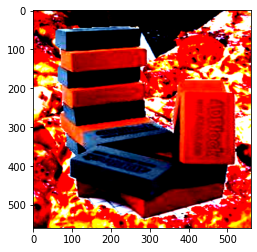

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, args, df, mask, seg, transform):
    self.args = args
    self.df = df
    self.mask = mask
    self.seg = seg
    self.transform = transform
    self.coco = sorted(glob('/content/val2014/*'))

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    sample = self.df.loc[idx]
    path, label = sample['img_path'], sample.iloc[2:].tolist()
    
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)  

    if self.seg:
      noise_path = random.choice(self.coco)
      noise = cv2.imread(noise_path, cv2.IMREAD_COLOR)
      noise = cv2.cvtColor(noise, cv2.COLOR_BGR2RGB).astype(np.uint8)  
      noise = resize_transform()(image = noise)['image'] 

      image_mask, noise_mask = segmentation(image, path)

      image = (image * image_mask).astype(float)
      noise = (noise * noise_mask).astype(float)

      image = image + noise

    mask = self.mask[int(sample['id'][-5:])]
    mask = resize_transform()(image = mask)['image']

    top_left, bottom_right = min_bounding_rect((mask>0.5))

    pad = 20
    ymin = np.clip(top_left[0]-pad, 0, 400)
    ymax = np.clip(bottom_right[0]+pad, 0, 400)
    xmin = np.clip(top_left[1]-pad, 0, 400)
    xmax = np.clip(bottom_right[1]+pad, 0, 400)

    image = image[ymin:ymax, xmin:xmax]
    image = self.transform()(image = image)['image'] 
    
    label = torch.tensor(label, dtype = torch.float)
    return image, label

if __name__ == "__main__":
  dataset = CustomDataset(args, train, train_mask, True, train_transform)
  i = random.randint(0, len(train))
  sample = dataset[i]
  plt.imshow(sample[0].permute(1, 2, 0))
  print(sample[-1])

# model

In [ ]:
def get_models(args):
  model_kwargs = dict(img_size = 560, patch_size=14, embed_dim=1408, depth=40, num_heads=16, mlp_ratio=6144 / 1408)
  vision_model = _create_beit(args.model_name, pretrained=False, **model_kwargs)
  checkpoint = torch.load(args.pretrained_path)
  vision_model.load_state_dict(checkpoint)
  return vision_model

class CustomModel(nn.Module):
  def __init__(self, args):
    super(CustomModel, self).__init__()
    self.enc = get_models(args)
    self.enc.head = nn.Identity()

    self.head = MLDecoder(num_classes = 10, 
                          initial_num_features = args.enc_dim, 
                          num_of_groups = -1,
                          decoder_embedding = 768, 
                          zsl = 0)

  def forward(self, x):
    x = self.enc.forward_features(x)
    x = self.head(x)
    return x

if __name__ == "__main__":
  model = CustomModel(args)
  output = model(sample[0].unsqueeze(0))
  print(output)

tensor([[ 0.0092,  1.5978, -2.1286,  0.3442,  3.4778,  1.1787,  1.0817, -0.5454,
          0.5113, -1.1788]], grad_fn=<AsStridedBackward0>)


# train

In [ ]:
class FocalLossV1(nn.Module):

    def __init__(self,
                 alpha=0.25,
                 gamma=2,
                 reduction='mean',):
        super(FocalLossV1, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.crit = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, label):
        '''
        Usage is same as nn.BCEWithLogits:
            >>> criteria = FocalLossV1()
            >>> logits = torch.randn(8, 19, 384, 384)
            >>> lbs = torch.randint(0, 2, (8, 19, 384, 384)).float()
            >>> loss = criteria(logits, lbs)
        '''
        probs = torch.sigmoid(logits)
        coeff = torch.abs(label - probs).pow(self.gamma).neg()
        log_probs = torch.where(logits >= 0,
                F.softplus(logits, -1, 50),
                logits - F.softplus(logits, 1, 50))
        log_1_probs = torch.where(logits >= 0,
                -logits + F.softplus(logits, -1, 50),
                -F.softplus(logits, 1, 50))
        loss = label * self.alpha * log_probs + (1. - label) * (1. - self.alpha) * log_1_probs
        loss = loss * coeff

        if self.reduction == 'mean':
            loss = loss.mean()
        if self.reduction == 'sum':
            loss = loss.sum()
        return loss

In [ ]:
import logging
from copy import deepcopy
from collections import OrderedDict

_logger = logging.getLogger(__name__)

class ModelEma:
    """ Model Exponential Moving Average (DEPRECATED)
    Keep a moving average of everything in the model state_dict (parameters and buffers).
    This version is deprecated, it does not work with scripted models. Will be removed eventually.
    This is intended to allow functionality like
    https://www.tensorflow.org/api_docs/python/tf/train/ExponentialMovingAverage
    A smoothed version of the weights is necessary for some training schemes to perform well.
    E.g. Google's hyper-params for training MNASNet, MobileNet-V3, EfficientNet, etc that use
    RMSprop with a short 2.4-3 epoch decay period and slow LR decay rate of .96-.99 requires EMA
    smoothing of weights to match results. Pay attention to the decay constant you are using
    relative to your update count per epoch.
    To keep EMA from using GPU resources, set device='cpu'. This will save a bit of memory but
    disable validation of the EMA weights. Validation will have to be done manually in a separate
    process, or after the training stops converging.
    This class is sensitive where it is initialized in the sequence of model init,
    GPU assignment and distributed training wrappers.
    """
    def __init__(self, model, decay=0.9999, device='', resume=''):
        # make a copy of the model for accumulating moving average of weights
        self.ema = deepcopy(model)
        self.ema.eval()
        self.decay = decay
        self.device = device  # perform ema on different device from model if set
        if device:
            self.ema.to(device=device)
        self.ema_has_module = hasattr(self.ema, 'module')
        if resume:
            self._load_checkpoint(resume)
        for p in self.ema.parameters():
            p.requires_grad_(False)

    def _load_checkpoint(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        assert isinstance(checkpoint, dict)
        if 'state_dict_ema' in checkpoint:
            new_state_dict = OrderedDict()
            for k, v in checkpoint['state_dict_ema'].items():
                # ema model may have been wrapped by DataParallel, and need module prefix
                if self.ema_has_module:
                    name = 'module.' + k if not k.startswith('module') else k
                else:
                    name = k
                new_state_dict[name] = v
            self.ema.load_state_dict(new_state_dict)
            _logger.info("Loaded state_dict_ema")
        else:
            _logger.warning("Failed to find state_dict_ema, starting from loaded model weights")

    def update(self, model):
        # correct a mismatch in state dict keys
        needs_module = hasattr(model, 'module') and not self.ema_has_module
        with torch.no_grad():
            msd = model.state_dict()
            for k, ema_v in self.ema.state_dict().items():
                if needs_module:
                    k = 'module.' + k
                model_v = msd[k].detach()
                if self.device:
                    model_v = model_v.to(device=self.device)
                ema_v.copy_(ema_v * self.decay + (1. - self.decay) * model_v)

In [ ]:
class CustomTrainer:
  def __init__(self, args, model, fold, data):
    self.model = model
    self.model_ema = ModelEma(model, decay=0.9997)

    self.save_dir = f'/content/drive/MyDrive/Dacon/포디블록 구조 추출 AI 경진대회/{args.folder}/fold{fold}'
    if not os.path.exists(self.save_dir):
      os.makedirs(self.save_dir)

    self.log_path = f'{self.save_dir}/log.txt'

    self.optimizer = AdamW(model.parameters(), lr = args.lr)
    self.scaler = torch.cuda.amp.GradScaler() 

    total_steps = int(len(data) * args.epoch_n/(args.batch_size * args.iters_to_accumulate))
    warmup_steps = int(total_steps * args.warmup_ratio)
    print('total_steps: ', total_steps)
    print('warmup_steps: ', warmup_steps)

    self.scheduler = get_cosine_schedule_with_warmup(self.optimizer, 
                                                     num_warmup_steps = warmup_steps, 
                                                     num_training_steps = total_steps)
    
    self.loss_fn = FocalLossV1()
    self.val_loss_fn = nn.BCEWithLogitsLoss()
    
    self.best_score = 0.0

    self.log(f'{fold}th fold trainer is ready')


  def run(self, args, train_loader, val_loader):
    for epoch in range(args.epoch_n):
      gc.collect()
      learning_rate = self.optimizer.param_groups[0]['lr']
      print('learning_rate: ', learning_rate)
      print(f'----- train, epoch{epoch + 1} -----')
      train_loss, train_score = self.train_function(args, train_loader)
      print(' ')
      print(f'train_loss: {train_loss:.6f}, train_score: {train_score:.6f}')

      self.log(f'learning_rate: {learning_rate}')
      self.log(f'----- train, epoch{epoch + 1} -----') 
      self.log(' ')
      self.log(f'train_loss: {train_loss:.6f}, train_score: {train_score:.6f}')
      

      print('----------------------------------')
      
      if epoch + 1 >= 3:
        print(f'----- val, epoch{epoch + 1} -----')
        with torch.no_grad():
          val_loss, val_score = self.val_function(args, val_loader)
        print(' ')
        print(f'val_loss: {val_loss:.6f}, val_score: {val_score:.6f}')

        self.log(f'----- val, epoch{epoch+1} -----') 
        self.log(' ')
        self.log(f'val_loss: {val_loss:.6f}, val_score: {val_score:.6f}')


        #if val_score >= self.best_score:
        torch.save(self.model_ema.ema.state_dict(), self.save_dir + '/best-acc-epoch' + f'{epoch+1}'.zfill(3) + '.bin')
        self.best_score = val_score
        print(f'model is saved when epoch is : {epoch + 1}')
        self.log(f'model is saved when epoch is : {epoch + 1}')

        print('----------------------------------')
        print(' ')
        self.log('----------------------------------')
        self.log(' ')


  def train_function(self, args, train_loader):
      self.model.train()

      total_loss = 0.0
      total_score = 0.0
      for bi, data in enumerate(tqdm(train_loader)):
        data = [x.to(args.device) for x in data]
        image, label = data

        with torch.cuda.amp.autocast():
          out = self.model(image)
          loss = self.loss_fn(out, label)
          loss = loss / args.iters_to_accumulate
        
        self.scaler.scale(loss).backward()  

        if (bi + 1) % args.iters_to_accumulate == 0:

          self.scaler.step(self.optimizer) 
          self.scaler.update()  
          self.optimizer.zero_grad()

          self.model_ema.update(self.model)

          self.scheduler.step()

        out = torch.sigmoid(out)
        pred = out.cpu().detach().numpy() > 0.5
        label = label.cpu().detach().numpy()
        batch_acc = (label == pred).mean()

        total_loss += loss.detach().cpu()
        total_score += batch_acc

      return total_loss/len(train_loader), total_score/len(train_loader)

  def val_function(self, args, val_loader):
    self.model_ema.ema.eval()

    total_loss = 0.0
    outs, labels = [], []
    for bi, data in enumerate(tqdm(val_loader)):
      data = [x.to(args.device) for x in data]
      image, label = data

      out = self.model_ema.ema(image)
      loss = self.val_loss_fn(out, label)

      total_loss += loss.detach().cpu() 

      out = torch.sigmoid(out)
      outs.extend(out.cpu().detach().numpy().tolist())
      labels.extend(label.cpu().detach().tolist())

    outs = np.array(outs)
    preds = outs > 0.5
    labels = np.array(labels)
    total_score = (labels == preds).mean()
    return total_loss/len(val_loader), total_score

  def log(self, message):
    with open(self.log_path, 'a+') as logger:
      logger.write(f'{message}\n')

# run

In [ ]:
if __name__ == "__main__":
  #for i in range(2, 5):
    i = 2
    seed_everything(args)
    
    train, folds = preprocess(args)
    train_df, val_df = folds[i]

    train_dataset = CustomDataset(args, train_df, train_mask, True, train_transform)
    val_dataset = CustomDataset(args, val_df, train_mask, False, val_transform)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = args.batch_size, num_workers = args.num_workers, shuffle = True, drop_last = True)
    test_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = args.batch_size, num_workers = args.num_workers, shuffle = False, drop_last = False)

    model = CustomModel(args)
    model = model.to(args.device)

    trainer = CustomTrainer(args, model, i + 1, train_df)
    result = trainer.run(args, train_dataloader, test_dataloader)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


total_steps:  32993
warmup_steps:  13197
learning_rate:  0.0
----- train, epoch1 -----


 44%|████▎     | 11500/26395 [51:09<1:09:55,  3.55it/s]

# inference

In [ ]:
class TestDataset(torch.utils.data.Dataset):
  def __init__(self, args, df, mask, transform):
    self.args = args
    self.df = df
    self.mask = mask
    self.transform = transform
    #self.normalize = Normalize(mean = args.mean, std = args.std, max_pixel_value = 255.0, p = 1.0)

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    sample = self.df.loc[idx]
    path = sample['img_path']
    
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.uint8)  
    #image = self.normalize(image = image)['image']

    mask = self.mask[int(sample['id'][-5:])]
    mask = resize_transform()(image = mask)['image']

    top_left, bottom_right = min_bounding_rect((mask>0.5))

    pad = 20
    ymin = np.clip(top_left[0]-pad, 0, 400)
    ymax = np.clip(bottom_right[0]+pad, 0, 400)
    xmin = np.clip(top_left[1]-pad, 0, 400)
    xmax = np.clip(bottom_right[1]+pad, 0, 400)

    image = image[ymin:ymax, xmin:xmax]
    image = self.transform()(image = image)['image'] 
    
    return image

if __name__ == "__main__":
  test = pd.read_csv('/content/test.csv')
  
  dataset = TestDataset(args, test, test_mask, val_transform)
  i = random.randint(0, len(test))
  sample = dataset[i]
  plt.imshow(sample.permute(1, 2, 0))
  pass

In [ ]:
def test_function(model, args, test_loader):
  model.eval()

  preds = []
  probs = []
  with torch.no_grad():
    for bi, image in enumerate(tqdm(test_loader)):
      out = model(image.to(args.device))

      out = torch.sigmoid(out)
      out = out.cpu().numpy()
      pred = out > 0.5
      pred = pred.astype(int)
      preds.extend(pred)
      probs.extend(out.tolist())
  return preds, probs

In [ ]:
# 학습시킨 모델 웨이트로 inference
test_df = pd.read_csv('/content/test.csv')

test_dataset = TestDataset(args, test_df, test_mask, val_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = args.batch_size, num_workers = args.num_workers, shuffle = False, drop_last = False)

model = CustomModel(args)
checkpoint = torch.load('/content/drive/MyDrive/Dacon/포디블록 구조 추출 AI 경진대회/result-model2/fold3/best-acc-epoch003.bin')
model.load_state_dict(checkpoint)
model.to(args.device)
model.eval()

_, probs = test_function(model, args, test_dataloader)
np.save('/content/drive/MyDrive/Dacon/포디블록 구조 추출 AI 경진대회/inference/model2_probs.npy', torch.Tensor(probs).numpy()) 

In [ ]:
# 제출한 모델 웨이트로 inference

test_df = pd.read_csv('/content/test.csv')

test_dataset = TestDataset(args, test_df, test_mask, val_transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = args.batch_size, num_workers = args.num_workers, shuffle = False, drop_last = False)

model = CustomModel(args)
checkpoint = torch.load('/content/drive/MyDrive/Dacon/포디블록 구조 추출 AI 경진대회/submission/model2_weight.bin')
model.load_state_dict(checkpoint)
model.to(args.device)
model.eval()

_, probs = test_function(model, args, test_dataloader)
np.save('/content/drive/MyDrive/Dacon/포디블록 구조 추출 AI 경진대회/inference/model2_probs.npy', torch.Tensor(probs).numpy()) 